# SpeechSlice Demonstration

This notebook contains the code flow for gathering speech signals, performing several short-time analyses, and then grouping the short segments together based on some short-time features. Along the way, several quantitative metrics are extracted, and many plots are presented to aid in visualization.

In [1]:
#################################################################
# Please run the following cell to import all necessary modules #
#################################################################
import librosa
import numpy as np
import sounddevice as sd
import scipy
from scipy.io import wavfile
from scipy.signal import find_peaks
from scipy.signal import lfilter
from scipy.integrate import simpson
from scipy.stats import chi2
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
import plotly.express as px
import plotly.io as pio
from dtw import *
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

from segmentation import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Defining commonly used parameters
audio_path_global = "demo_audio\SA1.WAV.wav"
samples_global, sample_rate_global = librosa.load(audio_path_global)

# Short-time Quantitative Metrics

### Normalizing and Plotting Speech Signal with TIMIT Dataset Segmentation

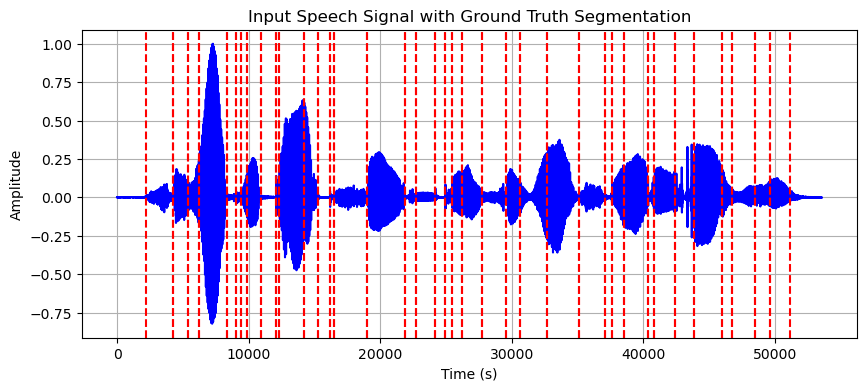

In [21]:
from scipy.io import wavfile

# compare with ground truth by examining the .phn file 
def compare_ground_truth(wav_file, phn_file):
    boundaries = [] 
    with open(phn_file, "r") as file:
        # Iterate through each line in the file
        for line in file:
            parts = line.split()
            # Append the extracted numbers to the list
            boundaries.append(int(parts[0]))
            boundaries.append(int(parts[1]))
        samples = boundaries[-1]
        boundaries = boundaries[2:]
        boundaries = boundaries[:-2]
    return boundaries

def normalize_and_plot(audio_file_path, ground_truth_file_path):

    # take input 
    sample_rate, audio_data = wavfile.read(audio_file_path)
    
    # normalize by using the maximum 
    # rms normalization has the risk of clipping, so we choose max normalization 

    # TODO: do this per window's max? 
    normalized_data = audio_data / np.max(np.abs(audio_data))

    # plot the normalized speech signal
    plt.figure(figsize=(10, 4))
    plt.plot(normalized_data, color='b')

    boundaries = compare_ground_truth(audio_file_path, ground_truth_file_path) 
    for i in range(len(boundaries)):
        plt.axvline(x=boundaries[i], color='r', linestyle='--') 
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Input Speech Signal with Ground Truth Segmentation')
    plt.grid(True)
    plt.show()

    return normalized_data, sample_rate

normalized_data, sample_rate = normalize_and_plot(audio_path_global, "demo_audio/SA1.PHN")

## Short-time Energy (STE) and Zero Crossing Rate (ZCR)

In [4]:
##################################################
# Importing the corresponding Python file        #
# Declaring visualization and auditory functions #
##################################################

from segment_voiced_unvoiced import *

def plot(energy,title,y_label):
    # Create a new figure
    plt.figure(figsize=(10, 4))
    # Plot the energy
    plt.plot(energy)
    # Set the title and labels
    plt.title(title)
    plt.xlabel('Frame')
    plt.ylabel(y_label)
    # Display the plot
    plt.show()

def play(voiced_segments, sample_rate):
    # Concatenate all voiced segments into one array for playback
    voiced_audio = np.concatenate(voiced_segments, axis=0)
    # Play the concatenated voiced audio
    sd.play(voiced_audio, samplerate=sample_rate)
    # Wait for the audio to finish playing
    sd.wait()

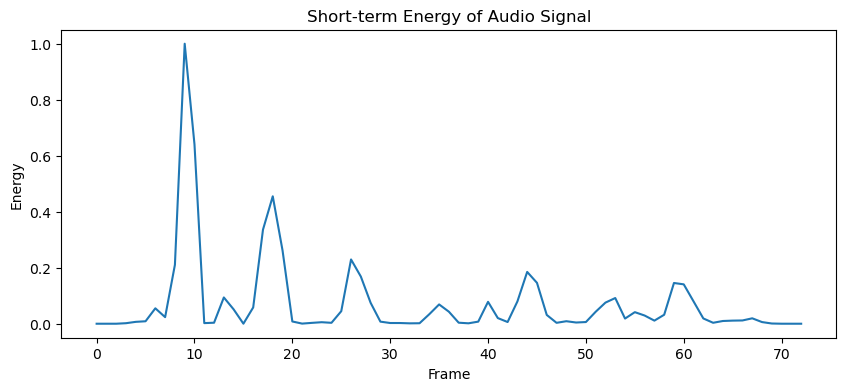

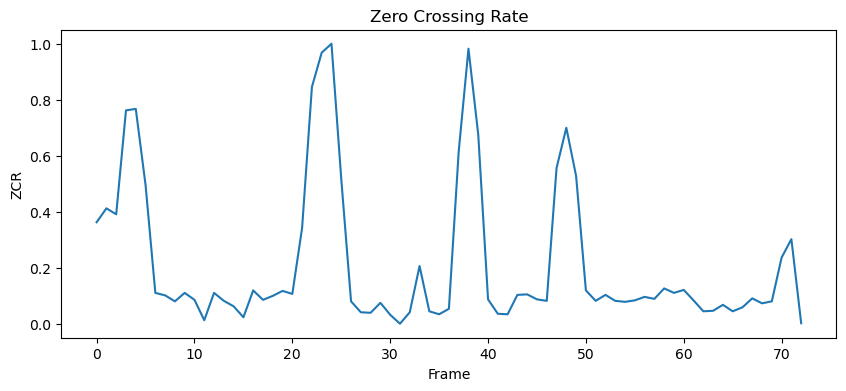

In [5]:
# Load the audio file
# y, sample_rate = librosa.load(audio_path_global)
# Segment audio file
voiced_segments, unvoiced_segments, energy, zcr= segment_audio(samples_global)

# Plot the Energy and Zero Crossing Rate
plot(energy,'Short-term Energy of Audio Signal','Energy')
plot(zcr,'Zero Crossing Rate','ZCR')

# Play separated segments
play(voiced_segments, sample_rate)


In [6]:
play(unvoiced_segments,sample_rate)

# Segmentation Techniques

In [7]:
# Instantiate a Segmentation instance to start using SpeechSlice functions 
speechSlice = Segmentation()

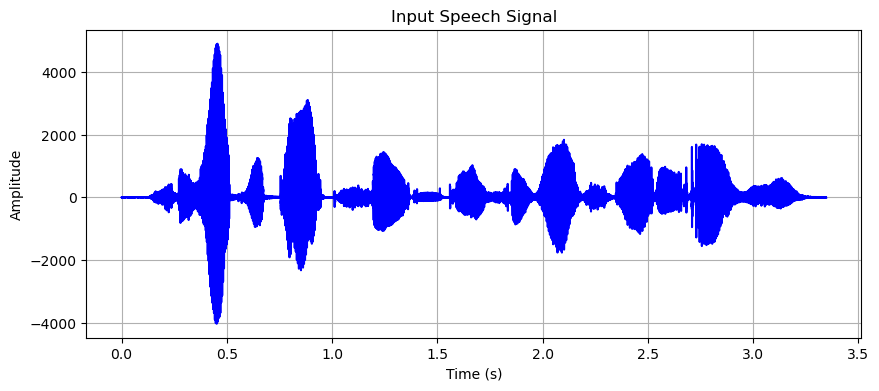

In [8]:
# running tests on input signal 1

# plot and play input signal 1 
sample_rate, audio_data = wavfile.read(audio_path_global)
sd.play(audio_data, sample_rate)
sd.wait()

audio_data, sample_rate = speechSlice.input_and_plot("demo_audio\SA1.WAV.wav", True) 


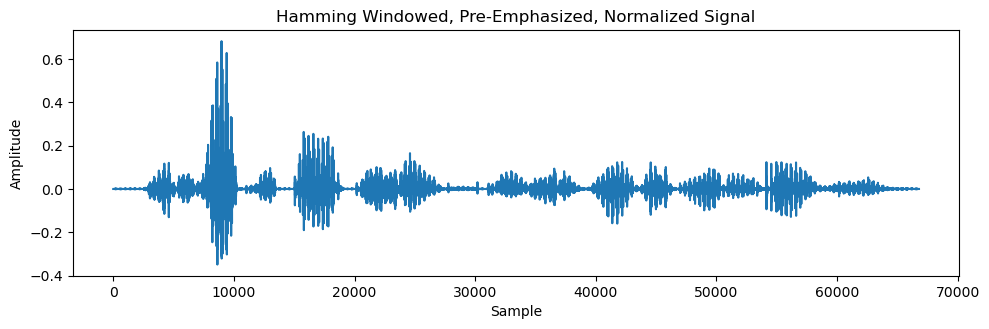

In [9]:
# short time window segmentation, normalize, and pre-emphasize
hamming_short_windows, hamming_signal = speechSlice.split_window_preemphasize(audio_data, sample_rate, 25, 5, plot=True)


## Peakiness Segmentation

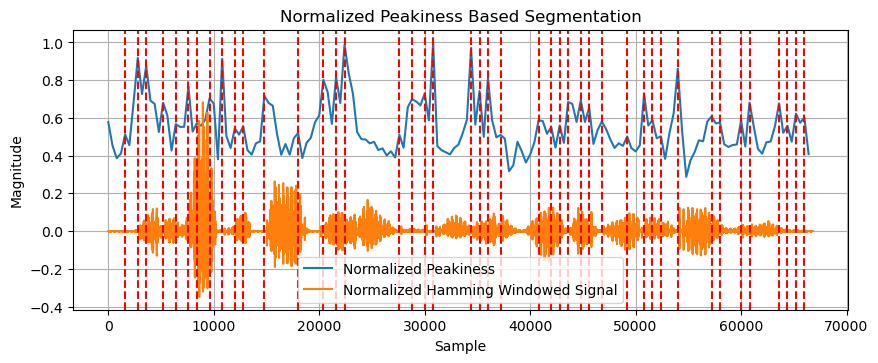

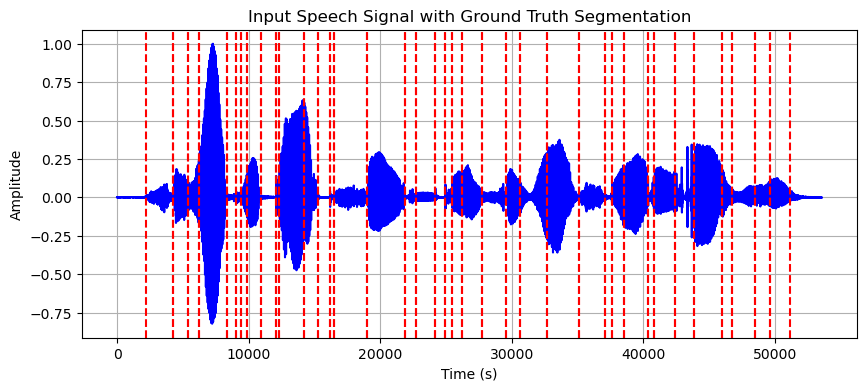

(array([ 0.00020412,  0.00081649,  0.00020412, ...,  0.00061237,
         0.00102062, -0.00224536]),
 16000)

In [22]:
# run peakiness segmentation 
peakiness_segmentation_boundaries = speechSlice.peakiness_segmentation(hamming_short_windows, peakiness_threshold=0.5)
normalize_and_plot(audio_path_global, "demo_audio/SA1.PHN")

## Formant Segmentation

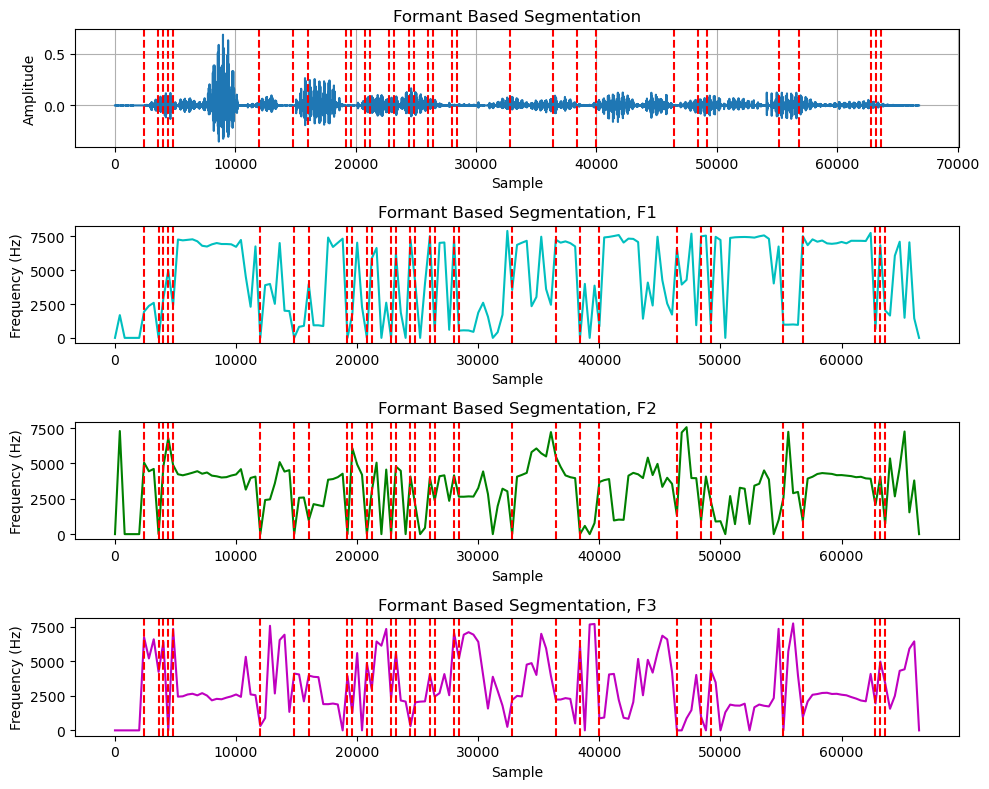

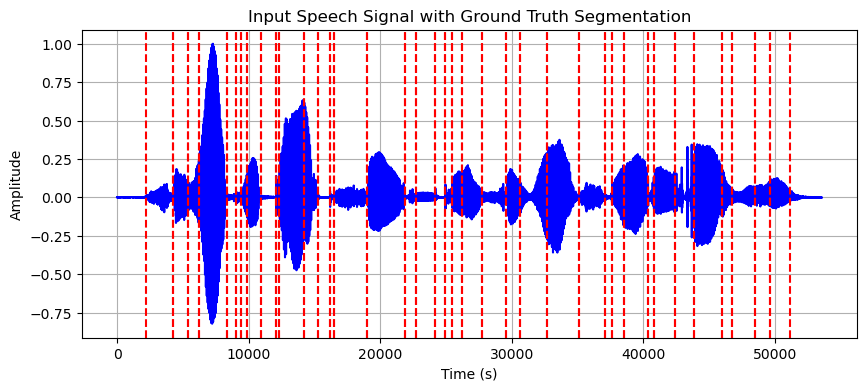

(array([ 0.00020412,  0.00081649,  0.00020412, ...,  0.00061237,
         0.00102062, -0.00224536]),
 16000)

In [23]:
# run formant segmentation
formant_segmentation_boundaries, formants_at_boundaries = speechSlice.formant_segmentation(hamming_short_windows, sample_rate)
normalize_and_plot(audio_path_global, "demo_audio/SA1.PHN")

## Teager Energy Segmentation

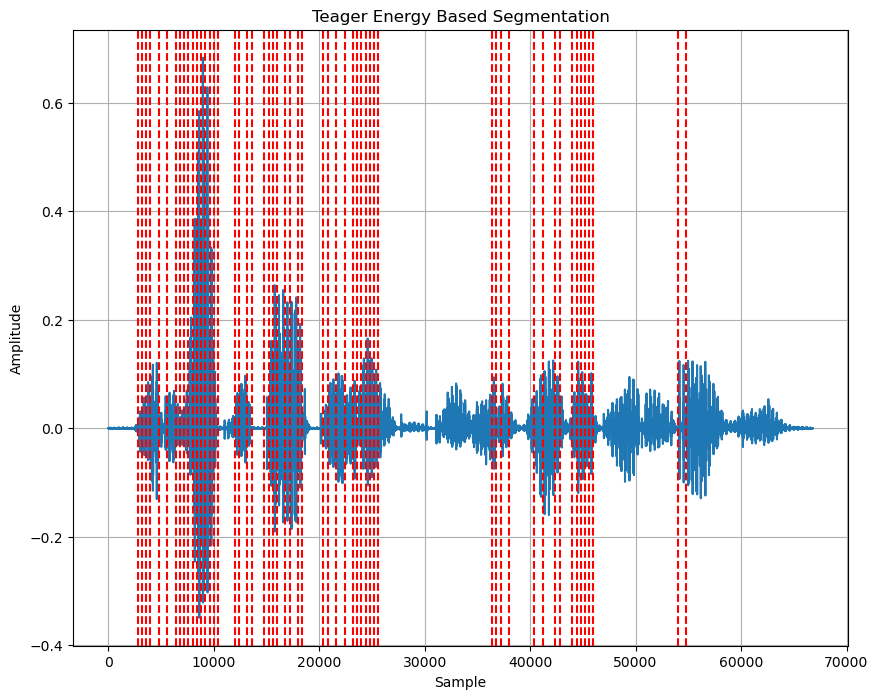

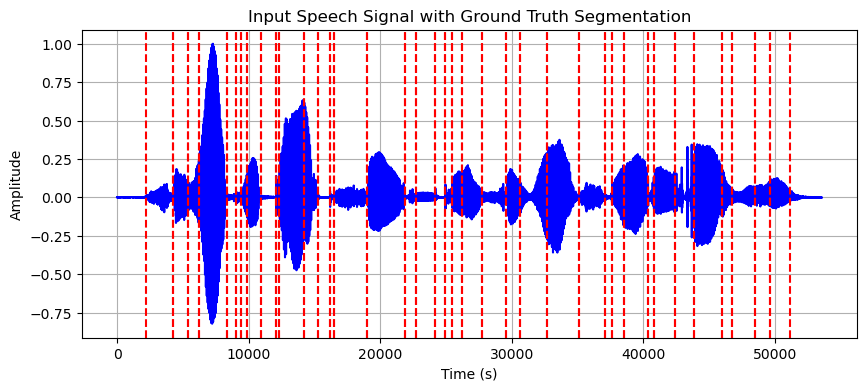

(array([ 0.00020412,  0.00081649,  0.00020412, ...,  0.00061237,
         0.00102062, -0.00224536]),
 16000)

In [24]:
# teager energy based segmentation 
teager_segmentation_boundaries = speechSlice.teager_energy_segmentation(hamming_short_windows, energy_threshold=0.009)
normalize_and_plot(audio_path_global, "demo_audio/SA1.PHN")

## Matusita Distance Segmentation

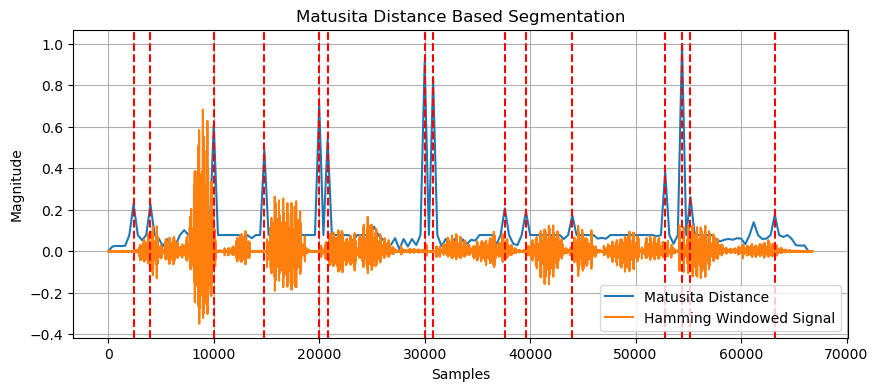

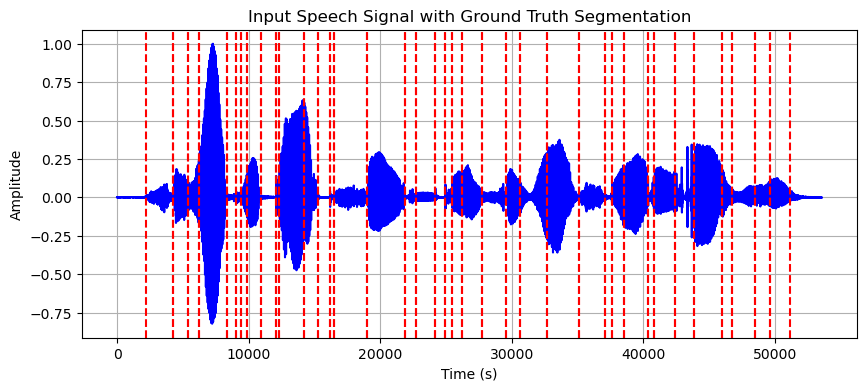

(array([ 0.00020412,  0.00081649,  0.00020412, ...,  0.00061237,
         0.00102062, -0.00224536]),
 16000)

In [25]:
# Matusita distance based segmentation 
matusita_segmentation_boundaries = speechSlice.matusita_dist_segmentation(hamming_short_windows, matusita_threshold=0.15)
normalize_and_plot(audio_path_global, "demo_audio/SA1.PHN")

## Fitting Process Segmentation

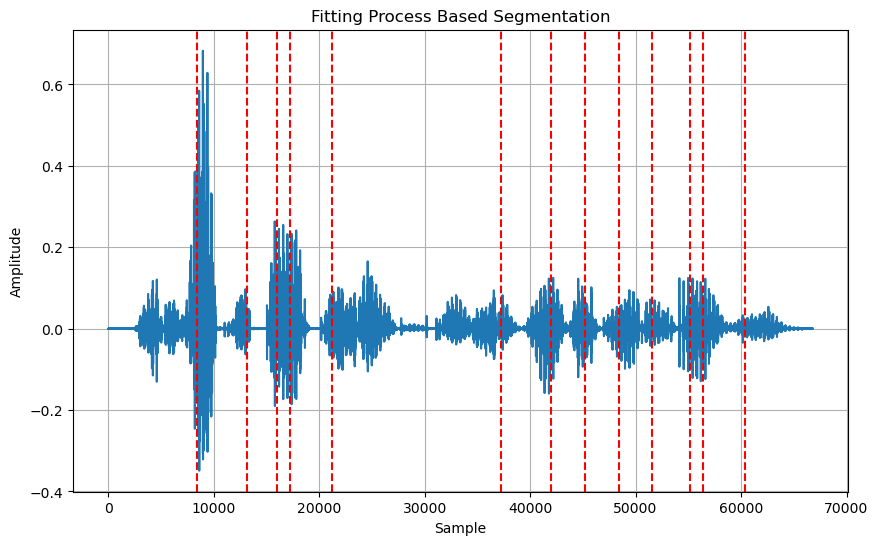

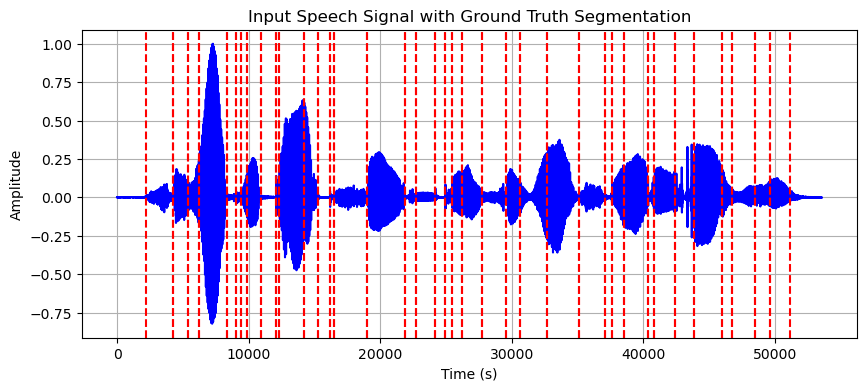

(array([ 0.00020412,  0.00081649,  0.00020412, ...,  0.00061237,
         0.00102062, -0.00224536]),
 16000)

In [31]:
# Fitting process segmentation 
fitting_proc_boundaries = speechSlice.fitting_proc_segmentation(hamming_short_windows, a=1, b=0.01, c=4)
normalize_and_plot(audio_path_global, "demo_audio/SA1.PHN")

# Vector Embeddings

In [25]:
##################################################
# Importing the corresponding Python file        #
##################################################

from vector_embeddings import Vector_Embeddings
vect_embed = Vector_Embeddings()

## Supervised labels for file 'Rhyme_Words.wav'

In [27]:
audio_path = 'Rhyme_Words.wav'
# Load the audio file
y, sample_rate = librosa.load(audio_path)
dtw_matrix_sup = vect_embed.mfcc_dtw_embed(y, sample_rate)

num_words = len(dtw_matrix_sup)

colors = ['blue']*((int)(num_words*0.23)) + ['red']*((int)(num_words*0.19)) + ['purple']*((int)(num_words*0.19)) + ['green']*((int)(num_words*0.15)) + ['orange']*((int)(num_words*0.23))
# Addressing rounding issues
colors = colors + ['orange']*(num_words - len(colors))
print("Shape of dtw_matrix is ", np.shape(dtw_matrix_sup))

TypeError: dtw() got an unexpected keyword argument 'distance_only'

## MFCC then DTW

In [28]:
dtw_matrix = vect_embed.mfcc_dtw_embed(samples_global, sample_rate_global)
print("Shape of dtw_matrix is ", np.shape(dtw_matrix))

TypeError: dtw() got an unexpected keyword argument 'distance_only'

## MFCC

In [18]:
mfcc_matrix = vect_embed.mfcc_embed(samples_global, sample_rate_global)
print("Shape of dtw_matrix is ", np.shape(mfcc_matrix))

Shape of dtw_matrix is  (132, 39)


# Dimensionality Reduction

In [19]:
from sklearn.decomposition import PCA

In [20]:
##################################################
#       Declaring visualization functions        #
##################################################

def visualize_3d(X_3d, fig_title, colors=None):
    df = pd.DataFrame(
            {
                "Feature 1": X_3d[:, 0],
                "Feature 2": X_3d[:, 1],
                "Feature 3": X_3d[:, 2],
            }
        )
    fig = px.scatter_3d(
            df,
            x="Feature 1",
            y="Feature 2",
            z="Feature 3",
            title=fig_title,
            color=colors,
            width=960,
            height=700,
        )
    fig.update_traces(
            marker=dict(size=5), selector=dict(mode="markers")
        )  # Customize if needed
    fig.show()


def visualize_2d(X_2d, fig_title, colors=None):
    df = pd.DataFrame(
            {"Feature 1": X_2d[:, 0], "Feature 2": X_2d[:, 1]}
        )
    fig = px.scatter(
        df, x="Feature 1", y="Feature 2", color=colors, title=fig_title
    )
    fig.show()

## Supervised labels for file 'Rhyme_Words.wav'

In [21]:
dtw_matrix_sup = np.array(dtw_matrix_sup)
dim_red_sup = PCA(n_components=3)
dim_red_sup.fit(dtw_matrix_sup)
print("The explained variance by each PCA component  is ", dim_red_sup.explained_variance_ratio_)
first_components_idxs = np.argsort(np.abs(dim_red_sup.components_[0]))[::-1]
second_components_idxs = np.argsort(np.abs(dim_red_sup.components_[1]))[::-1]
third_components_idxs = np.argsort(np.abs(dim_red_sup.components_[2]))[::-1]

print("The 1st PCA component expressed as a linear combination of the original features (columns): ")
print(dim_red_sup.components_[0][first_components_idxs[0]], " of component ", first_components_idxs[0])
print(dim_red_sup.components_[0][first_components_idxs[1]], " of component ", first_components_idxs[1])
print(dim_red_sup.components_[0][first_components_idxs[2]], " of component ", first_components_idxs[2])

print("The 2nd PCA component expressed as a linear combination of the original features (columns): ")
print(dim_red_sup.components_[1][second_components_idxs[0]], " of component ", second_components_idxs[0])
print(dim_red_sup.components_[1][second_components_idxs[1]], " of component ", second_components_idxs[1])
print(dim_red_sup.components_[1][second_components_idxs[2]], " of component ", second_components_idxs[2])

print("The 3rd PCA component expressed as a linear combination of the original features (columns): ")
print(dim_red_sup.components_[2][third_components_idxs[0]], " of component ", third_components_idxs[0])
print(dim_red_sup.components_[2][third_components_idxs[1]], " of component ", third_components_idxs[1])
print(dim_red_sup.components_[2][third_components_idxs[2]], " of component ", third_components_idxs[2])

threeD_vectors_sup = dim_red_sup.transform(dtw_matrix_sup)
visualize_3d(threeD_vectors_sup, "DTW Word Vectors Only 3 Dimensions", colors)
twoD_vectors_sup = threeD_vectors_sup[:, 0:2]
visualize_2d(twoD_vectors_sup, "DTW Word Vectors Only 2 Dimensions", colors)

# If you experience the error "Mime type rendering requires nbformat>=4.2.0 but it is not installed"
# Type the following in the terminal: "pip install --upgrade nbformat"
# Then, restart the kernal and re-runn the cells

The explained variance by each PCA component  is  [0.8637098  0.07305386 0.02467248]
The 1st PCA component expressed as a linear combination of the original features (columns): 
0.05944206288368837  of component  89
0.0590721149460251  of component  86
0.05895625423612246  of component  326
The 2nd PCA component expressed as a linear combination of the original features (columns): 
0.08054666194769146  of component  369
0.07970222859016259  of component  231
0.07843855817404957  of component  277
The 3rd PCA component expressed as a linear combination of the original features (columns): 
0.12495709132446395  of component  519
0.124511730357032  of component  55
0.11747485229323211  of component  51


## MFCC then DTW

In [22]:
dtw_matrix = np.array(dtw_matrix)
dim_red = PCA(n_components=3)
dim_red.fit(dtw_matrix)
print("The explained variance by each PCA component  is ", dim_red.explained_variance_ratio_)
first_components_idxs = np.argsort(np.abs(dim_red.components_[0]))[::-1]
second_components_idxs = np.argsort(np.abs(dim_red.components_[1]))[::-1]
third_components_idxs = np.argsort(np.abs(dim_red.components_[2]))[::-1]

print("The 1st PCA component expressed as a linear combination of the original features (columns): ")
print(dim_red.components_[0][first_components_idxs[0]], " of component ", first_components_idxs[0])
print(dim_red.components_[0][first_components_idxs[1]], " of component ", first_components_idxs[1])
print(dim_red.components_[0][first_components_idxs[2]], " of component ", first_components_idxs[2])

print("The 2nd PCA component expressed as a linear combination of the original features (columns): ")
print(dim_red.components_[1][second_components_idxs[0]], " of component ", second_components_idxs[0])
print(dim_red.components_[1][second_components_idxs[1]], " of component ", second_components_idxs[1])
print(dim_red.components_[1][second_components_idxs[2]], " of component ", second_components_idxs[2])

print("The 3rd PCA component expressed as a linear combination of the original features (columns): ")
print(dim_red.components_[2][third_components_idxs[0]], " of component ", third_components_idxs[0])
print(dim_red.components_[2][third_components_idxs[1]], " of component ", third_components_idxs[1])
print(dim_red.components_[2][third_components_idxs[2]], " of component ", third_components_idxs[2])

threeD_vectors_dtw = dim_red.transform(dtw_matrix)
visualize_3d(threeD_vectors_dtw, "DTW Word Vectors Only 3 Dimensions")
twoD_vectors_dtw = threeD_vectors_dtw[:, 0:2]
visualize_2d(twoD_vectors_dtw, "DTW Word Vectors Only 2 Dimensions")

# If you experience the error "Mime type rendering requires nbformat>=4.2.0 but it is not installed"
# Type the following in the terminal: "pip install --upgrade nbformat"
# Then, restart the kernal and re-runn the cells

The explained variance by each PCA component  is  [0.59504542 0.18556515 0.0849705 ]
The 1st PCA component expressed as a linear combination of the original features (columns): 
-0.1895302415548341  of component  52
-0.178579839987087  of component  0
0.17140625005476032  of component  68
The 2nd PCA component expressed as a linear combination of the original features (columns): 
0.20342629238336335  of component  58
0.2020081764256632  of component  56
0.20020608149482536  of component  48
The 3rd PCA component expressed as a linear combination of the original features (columns): 
0.2814106102729727  of component  14
0.273014145811681  of component  32
0.2709551558051504  of component  80


## MFCC

In [23]:
mfcc_matrix_matrix = np.array(mfcc_matrix)
dim_red.fit(mfcc_matrix)
print("The explained variance by each PCA component  is ", dim_red.explained_variance_ratio_)
first_components_idxs = np.argsort(np.abs(dim_red.components_[0]))[::-1]
second_components_idxs = np.argsort(np.abs(dim_red.components_[1]))[::-1]
third_components_idxs = np.argsort(np.abs(dim_red.components_[2]))[::-1]

print("The 1st PCA component expressed as a linear combination of the original features (columns): ")
print(dim_red.components_[0][first_components_idxs[0]], " of MFCC coefficient ", first_components_idxs[0])
print(dim_red.components_[0][first_components_idxs[1]], " of MFCC coefficient ", first_components_idxs[1])
print(dim_red.components_[0][first_components_idxs[2]], " of MFCC coefficient ", first_components_idxs[2])

print("The 2nd PCA component expressed as a linear combination of the original features (columns): ")
print(dim_red.components_[1][second_components_idxs[0]], " of MFCC coefficient ", second_components_idxs[0])
print(dim_red.components_[1][second_components_idxs[1]], " of MFCC coefficient ", second_components_idxs[1])
print(dim_red.components_[1][second_components_idxs[2]], " of MFCC coefficient ", second_components_idxs[2])

print("The 3rd PCA component expressed as a linear combination of the original features (columns): ")
print(dim_red.components_[2][third_components_idxs[0]], " of MFCC coefficient ", third_components_idxs[0])
print(dim_red.components_[2][third_components_idxs[1]], " of MFCC coefficient ", third_components_idxs[1])
print(dim_red.components_[2][third_components_idxs[2]], " of MFCC coefficient ", third_components_idxs[2])

threeD_vectors_mfcc = dim_red.transform(mfcc_matrix)
visualize_3d(threeD_vectors_mfcc, "DTW Word Vectors Only 3 Dimensions")
twoD_vectors_mfcc = threeD_vectors_mfcc[:, 0:2]
visualize_2d(twoD_vectors_mfcc, "DTW Word Vectors Only 2 Dimensions")

# If you experience the error "Mime type rendering requires nbformat>=4.2.0 but it is not installed"
# Type the following in the terminal: "pip install --upgrade nbformat"
# Then, restart the kernal and re-runn the cells

The explained variance by each PCA component  is  [0.58662444 0.17911543 0.06900853]
The 1st PCA component expressed as a linear combination of the original features (columns): 
-0.87984586  of MFCC coefficient  0
-0.31873858  of MFCC coefficient  1
0.2550623  of MFCC coefficient  2
The 2nd PCA component expressed as a linear combination of the original features (columns): 
-0.75610274  of MFCC coefficient  1
0.35918522  of MFCC coefficient  3
-0.2831095  of MFCC coefficient  4
The 3rd PCA component expressed as a linear combination of the original features (columns): 
0.5631896  of MFCC coefficient  3
0.46415555  of MFCC coefficient  4
0.2900597  of MFCC coefficient  30


# Applying a DBScan Model

## Supervised labels for file 'Rhyme_Words.wav'

In [24]:
db_model_threeD_sup = DBSCAN(eps=10.0, min_samples=3).fit(threeD_vectors_sup)
db_colors_threeD_sup = db_model_threeD_sup.labels_
visualize_3d(threeD_vectors_sup, "DBScan on 3D DTW Vectors", db_colors_threeD_sup)

db_model_twoD_sup = DBSCAN(eps=10.0, min_samples=3).fit(twoD_vectors_sup)
db_colors_twoD_sup = db_model_twoD_sup.labels_
visualize_2d(twoD_vectors_sup, "DBScan on 2D DTW Vectors", db_colors_twoD_sup)

## MFCC then DTW

In [25]:
db_model_threeD_dtw = DBSCAN(eps=10.0, min_samples=3).fit(threeD_vectors_dtw)
db_colors_threeD_dtw = db_model_threeD_dtw.labels_
visualize_3d(threeD_vectors_dtw, "DBScan on 3D DTW Vectors", db_colors_threeD_dtw)

db_model_twoD_dtw = DBSCAN(eps=10.0, min_samples=3).fit(twoD_vectors_dtw)
db_colors_twoD_dtw = db_model_twoD_dtw.labels_
visualize_2d(twoD_vectors_dtw, "DBScan on 2D DTW Vectors", db_colors_twoD_dtw)

## MFCC

In [26]:
db_model_threeD_mfcc = DBSCAN(eps=10.0, min_samples=3).fit(threeD_vectors_mfcc)
db_colors_threeD_mfcc = db_model_threeD_mfcc.labels_
visualize_3d(threeD_vectors_mfcc, "DBScan on 3D DTW Vectors", db_colors_threeD_mfcc)

db_model_twoD_mfcc = DBSCAN(eps=10.0, min_samples=3).fit(twoD_vectors_mfcc)
db_colors_twoD_mfcc = db_model_twoD_mfcc.labels_
visualize_2d(twoD_vectors_mfcc, "DBScan on 2D DTW Vectors", db_colors_twoD_mfcc)